# Modelo


Modelo elegido para la competencia 01

Si hay tiempo ver si se puede reemplazar pandas por polars

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle

In [2]:
!gsutil cp /home/eanegrin/buckets/b1/datasets/competencia_02_fe_v01.parquet /home/eanegrin/datasets/

Copying file:///home/eanegrin/buckets/b1/datasets/competencia_02_fe_v01.parquet...
- [1 files][  7.1 GiB/  7.1 GiB]                                                
Operation completed over 1 objects/7.1 GiB.                                      


In [3]:
# base_path = '/content/drive/MyDrive/DMEyF/2024/'
base_path = 'C:/Eugenio/Maestria/DMEyF/'
# base_path = '/home/eanegrin/buckets/b1/'

dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_02_fe_v01_undersampled.parquet'

ganancia_acierto = 273000
costo_estimulo = 7000

# agregue sus semillas
semillas = [122219, 109279, 400391, 401537, 999961]

# data = pd.read_parquet('/home/eanegrin/datasets/' + dataset_file)
data = pd.read_parquet(dataset_path + dataset_file)

In [4]:
X_train = data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = data['clase_binaria1'] # Solo BAJA+2
y_train_binaria2 = data['clase_binaria2'] # junta a los 2 BAJA
w_train = data['clase_peso']

In [9]:
# No imputo nulos porque el modelo los maneja

# imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# Xif = imp_mean.fit_transform(X_test)

Para evaluar la calidad del modelo, crearemos nuestra propia función de evaluación que calcule la ganancia. La razón de incluir los pesos es precisamente para poder implementar esta función de evaluación de manera adecuada. Al combinar las clases *BAJA+1* y *BAJA+2* en una sola, necesitamos una forma de diferenciarlas, y es aquí donde entra en juego el *weight*. Este parámetro nos permitirá distinguir entre ambas clases al momento de evaluarlas dentro del algoritmo.


In [5]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

# Parámetros del modelo.
params = {
    'objective': 'binary',
    'metric': 'gan_eval',
    'boosting_type': 'gbdt',
    'max_bin': 31,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.7,
    'verbose': 0
}

# Optimizacion

LGBM necesita su propio tipo de Datasets:

In [6]:
train_data1 = lgb.Dataset(X_train, label=y_train_binaria1, weight=w_train)
train_data2 = lgb.Dataset(X_train, label=y_train_binaria2, weight=w_train)

A continuación, compararemos las dos clases. Utilizaremos para medir la calidad de las clases (y de los parámetros), la función **cv** que viene *out-of-the-box*

In [7]:
cv_results1 = lgb.cv(
    params,
    train_data1,
    num_boost_round=150,
    feval=lgb_gan_eval,
    nfold=5,
    seed=semillas[0]
)

cv_results2 = lgb.cv(
    params,
    train_data2,
    num_boost_round=150,
    feval=lgb_gan_eval,
    nfold=5,
    seed=semillas[0]
)

Y vizualizamos los resultados de ambas ejecuciones:

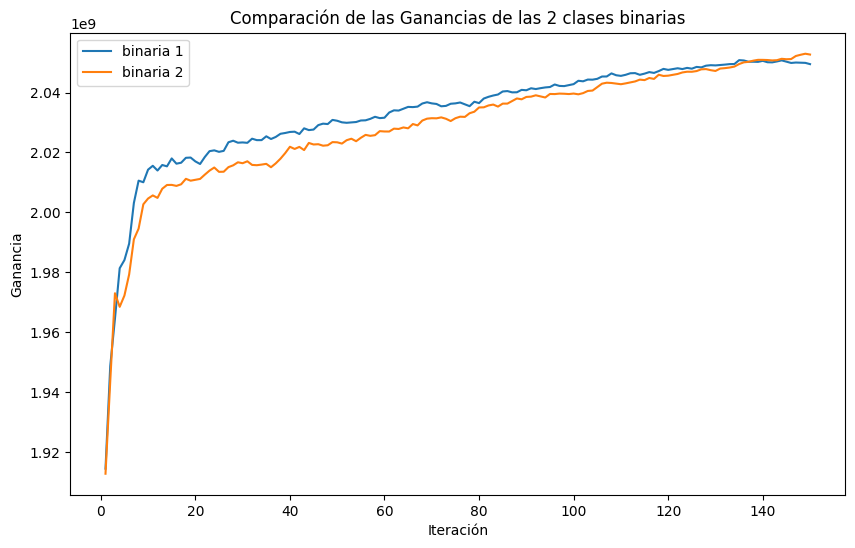

In [8]:
df_ganancias = pd.DataFrame({
    'binaria1': cv_results1['valid gan_eval-mean'],
    'binaria2': cv_results2['valid gan_eval-mean'],
    'Iteracion': range(1, len(cv_results1['valid gan_eval-mean']) + 1)
})

# Normalizamos la ganancias
df_ganancias['binaria1'] = df_ganancias['binaria1']*5
df_ganancias['binaria2'] = df_ganancias['binaria2']*5

plt.figure(figsize=(10, 6))
sns.lineplot(x='Iteracion', y='binaria1', data=df_ganancias, label='binaria 1')
sns.lineplot(x='Iteracion', y='binaria2', data=df_ganancias, label='binaria 2')
plt.title('Comparación de las Ganancias de las 2 clases binarias')
plt.xlabel('Iteración')
plt.ylabel('Ganancia')
plt.legend()
plt.show()


Se observa una ligera mejora al combinar las clases en modelos sencillos. Dado que cada pequeña mejora es importante, continuaremos utilizando esta estrategia.

A continuación, procederemos a optimizar **LightGBM** utilizando la librería **Optuna**. Cabe destacar que las optimizaciones que realizaremos son básicas y están diseñadas para ejecutarse en pocos minutos. Será su responsabilidad ampliar tanto el rango de búsqueda como el tiempo de optimización para obtener un modelo más competitivo.


In [9]:
def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 8, 100), # segun statquest esto deberia ir de 8 a 32
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.05), # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 1000),
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0),
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0),

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semillas[0],
        'verbose': -1
    }
    
    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria2, # eligir la clase
                              weight=w_train)
    
    # print(f"Learning Rate: {learning_rate}, Type: {type(learning_rate)}")
    
    # Use callbacks for early stopping
    early_stopping_cb = lgb.early_stopping(stopping_rounds=50) # creo que en min_delta le tendria que pasar un parametro con la ganancia que considero irrelevante
        
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=1000, # modificar, subit y subir... y descomentar la línea inferior (ahora le puso 100 para mostrarnos, pero hay que ponerle un numero alto, 10.000, 200.000)
        # early_stopping_rounds= int((50 + 5) / learning_rate), # (ale dijo que lo mas comun es que sea 1/learning rate)
        # early_stopping_rounds = 50,
        callbacks=[early_stopping_cb],
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )
    
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5 # funcion objetivo, en el proximo paso le digo si quiero maximizarla o minimizarla.

In [10]:
storage_name = "sqlite:///" + db_path + "optimization_lgbm.db"
study_name = "competencia2_lgbm_v01" # UPDATE

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2024-11-04 10:52:54,712] Using an existing study with name 'competencia2_lgbm_v01' instead of creating a new one.


In [ ]:
study.optimize(objective, n_trials=100)

Training until validation scores don't improve for 50 rounds


Analizamos los resultados as usual

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
plot_param_importances(study)

El **learning rate** es un parámetro que tiene que ir acompañado por más árboles.

In [ ]:
plot_slice(study)

In [ ]:
plot_contour(study)

In [ ]:
plot_contour(study, params=['num_leaves','min_data_in_leaf'] )

Y finalmente tomamos el mejor modelo y lo entrenamos con la totalidad de los datos

In [ ]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


Observamos la variables más importantes para el modelo:

In [ ]:
lgb.plot_importance(model, figsize=(10, 20))
plt.show()


Y si queremos tener las variables más importantes en forma de *Dataframe*:

In [ ]:
importances = model.feature_importance()
feature_names = X_train.columns.tolist()
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df[importance_df['importance'] > 0]


Para guardar el modelo para poder utilizarlo más adelante, no es necesario guardarlo como *pickle*, la librería nos permite guardarlo en formato texto

In [ ]:
model.save_model(modelos_path + 'lgb_v003.txt')

# Punto de corte optimo

In [ ]:
y_pred_lgm = model.predict(X_train)

In [ ]:
ganancia = np.where(y_train_binaria1 == 1, ganancia_acierto, 0) - np.where(y_train_binaria1 == 0, costo_estimulo, 0) # uso la binaria 1 porque es la que solo considera a los BAJA+2

idx = np.argsort(y_pred_lgm)[::-1]

ganancia = ganancia[idx]
y_pred_lgm = y_pred_lgm[idx]

ganancia_cum = np.cumsum(ganancia)

In [ ]:
piso_envios = 4000
techo_envios = 20000

plt.figure(figsize=(10, 6))
plt.plot(y_pred_lgm[piso_envios:techo_envios], ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.title('Curva de Ganancia')
plt.xlabel('Predicción de probabilidad')
plt.ylabel('Ganancia')
plt.axvline(x=0.025, color='g', linestyle='--', label='Punto de corte a 0.025')
plt.legend()
plt.show()

En vez de mirar el punto de corte, empezaremos a pensar en cuál es la cantidad máxima de clientes que se deben estimular. Si cambiamos a esto, veremos que el gráfico anterior se ve así

In [ ]:
piso_envios = 4000
techo_envios = 20000

ganancia_max = ganancia_cum.max()
gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]

plt.figure(figsize=(10, 6))
plt.plot(range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios), ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.axvline(x=gan_max_idx, color='g', linestyle='--', label=f'Punto de corte a la ganancia máxima {gan_max_idx}')
plt.axhline(y=ganancia_max, color='r', linestyle='--', label=f'Ganancia máxima {ganancia_max}')
plt.title('Curva de Ganancia')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()

# Backtesting

Entreno con marzo y estimo para abril porque eran los unicos 2 meses para los cuales tengo todas las varibales temporales

In [ ]:
train_data = data[data['foto_mes'] == 202103]
test_data = data[data['foto_mes'] == 202104]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_class = test_data['clase_ternaria']
w_test = test_data['clase_peso']

Entrenamos el modelo solo con los datos de marzo

In [ ]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

In [ ]:
train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

In [ ]:
model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


obtenemos la predicción de **Abril**

In [ ]:
y_pred_lgm = model.predict(X_test)

In [ ]:
ganancia = np.where(y_test_binaria1 == 1, ganancia_acierto, 0) - np.where(y_test_binaria1 == 0, costo_estimulo, 0)

idx = np.argsort(y_pred_lgm)[::-1]

ganancia = ganancia[idx]
y_pred_lgm = y_pred_lgm[idx]

ganancia_cum = np.cumsum(ganancia)


In [ ]:
piso_envios = 4000
techo_envios = 20000

plt.figure(figsize=(10, 6))
plt.plot(y_pred_lgm[piso_envios:techo_envios], ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.title('Curva de Ganancia')
plt.xlabel('Predicción de probabilidad')
plt.ylabel('Ganancia')
plt.axvline(x=0.025, color='g', linestyle='--', label='Punto de corte a 0.025')
plt.legend()
plt.show()


In [ ]:
piso_envios = 4000
techo_envios = 20000

ganancia_max = ganancia_cum.max()
gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]

plt.figure(figsize=(10, 6))
plt.plot(range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios), ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.axvline(x=gan_max_idx, color='g', linestyle='--', label=f'Punto de corte a la ganancia máxima {gan_max_idx}')
plt.axhline(y=ganancia_max, color='r', linestyle='--', label=f'Ganancia máxima {ganancia_max}')
plt.title('Curva de Ganancia')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()


# Generar prediccion para Kaggle

In [ ]:
# Mejores parametros que habian surgido de la optimizacion de Optuna

best_iter = 381 # cantidad de arboles del mejor modelo

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': 57,
    'learning_rate': 0.02430667011066182,
    'min_data_in_leaf': 741,
    'feature_fraction': 0.43258351876617523,
    'bagging_fraction': 0.4885097776912656,
    'seed': 122219,
    'verbose': 0
}

# y cantidad optima de envios segun backtesting
corte = 10669

In [ ]:
train_data = data[data['foto_mes'].isin([202104])]
future_data = data[data['foto_mes'] == 202106]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = future_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)

Entreno el modelo con los datos de abril y los parametros optimos de Optuna

In [ ]:
train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

In [ ]:
model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


Hago la prediccion para junio

In [ ]:
y_pred_lgm = model.predict(X_test)

In [ ]:
# Agrego la prediccion en el dataset de test
X_test['pred_lgm'] = y_pred_lgm

#  ordeno por probabilidad para marcar a quienes les vamos a enviar el estimulo
idx = np.argsort(y_pred_lgm)[::-1]
X_test.reset_index(drop=True, inplace=True) # reseteo el index para poder ordenar por idx, sino en index tenia por default el numero de fila del dataframe original "data"
X_test = X_test.iloc[idx]

# genero la columna con 1s para los que van a recibir el estimulo, 0 para todo el resto
envios = np.zeros(len(X_test), dtype=int)
envios[:corte] = 1
X_test['Predicted'] = envios

# otra forma seria:
# X_test['Predicted'] = 0
# X_test.loc[:gan_max_idx-1, 'Predicted'] = 1

Genero el archivo para kaggle

In [ ]:
output = X_test[['numero_de_cliente', 'Predicted']]

file_name = 'results_v03_01.csv'
output_path = base_path + 'exp/KA2001/' + file_name

# output.to_csv(output_path, index=False)

# Probando distintas semillas y puntos de corte

In [ ]:
# Voy a probar 20 puntos de corte para cada semilla (total 100 envios)

semillas
puntos_corte = np.linspace(9000, 13000, 20).astype(int)

In [ ]:
# counter = 0

# for semilla in semillas:
    
#     # entrenamos el modelo con la semilla
#     params['seed'] = semilla
#     model = lgb.train(params, train_data, num_boost_round=best_iter)
    
#     # predecimos para junio
#     X_test = future_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1).copy()
#     y_pred_lgm = model.predict(X_test)
#     X_test['pred_lgm'] = y_pred_lgm
    
#     # ordeno de mayor probabilidad de baja a menor
#     idx = np.argsort(y_pred_lgm)[::-1]
#     X_test.reset_index(drop=True, inplace=True)
#     X_test = X_test.iloc[idx]
    
#     for corte in puntos_corte:
        
#         envios = np.zeros(len(X_test), dtype=int)
#         envios[:corte] = 1
#         X_test['Predicted'] = envios
        
#         output = X_test[['numero_de_cliente', 'Predicted']]
        
#         counter += 1
#         file_name = f'results_v03_{counter}.csv'
#         output_path = base_path + 'exp/KA2001/' + file_name
        
#         output.to_csv(output_path, index=False)
                
#         print(f'{output_path} --- seed: {semilla}, corte: {corte}')

Subir a kaggle

In [ ]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
import time

api = KaggleApi()
api.authenticate()

competition = 'dm-ey-f-2024-primera'
files_path = 'C:/Eugenio/Maestria/DMEyF/exp/KA2001/'
modelo = 'v03'

In [ ]:
# diccionario con la semilla y el corte de cada version
combinations = {}
counter = 1
for semilla in semillas:
    for corte in puntos_corte:
        combinations[counter] = {'seed':semilla,'corte':int(corte)}
        counter += 1

# path de cada version        
files = [f'{files_path}results_{modelo}_{i}.csv' for i in range(1,101)]

# descripcion de cada edicion
descriptions= [
    f"seed = {combinations[i]['seed']}, corte = {combinations[i]['corte']}"
    for i in range(1, len(combinations)+1)
]

In [ ]:
archivos = []
scores = []
descripciones = []

for i in range(len(files)):

    submitted = False
    while submitted == False:
        try:
            # Submit the file
            api.competition_submit(file_name=files[i],
                                   message=descriptions[i],
                                   competition=competition)
        except Exception as e:
            print(f'Error al subir {files[i]}: {e}')
            time.sleep(10)
        else:
            submitted = True 

            # Esperamos un poco para que kaggle no tire error
            time.sleep(10)

            submissions = api.competition_submissions(competition, page_size=1) # traigo solo la ultima
            ultima = submissions[0]
            
            archivo = ultima.fileName
            public_score = ultima.publicScore
            descripcion = ultima.description
            
            archivos.append(archivo)
            scores.append(public_score)
            descripciones.append(descripcion)
            
            print(f'{archivo} subido con exito, public score:{public_score}')
            
resultados = pd.DataFrame({
    'Archivo': archivos,
    'Public score': scores,
    'Description':descripciones
})

In [ ]:
# guardo los resultados

resultados = pd.DataFrame(
    {'Archivo': {0: 'results_v03_1.csv',
                1: 'results_v03_2.csv',
                2: 'results_v03_3.csv',
                3: 'results_v03_4.csv',
                4: 'results_v03_5.csv',
                5: 'results_v03_6.csv',
                6: 'results_v03_7.csv',
                7: 'results_v03_8.csv',
                8: 'results_v03_9.csv',
                9: 'results_v03_10.csv',
                10: 'results_v03_11.csv',
                11: 'results_v03_12.csv',
                12: 'results_v03_13.csv',
                13: 'results_v03_14.csv',
                14: 'results_v03_15.csv',
                15: 'results_v03_16.csv',
                16: 'results_v03_17.csv',
                17: 'results_v03_18.csv',
                18: 'results_v03_19.csv',
                19: 'results_v03_20.csv',
                20: 'results_v03_21.csv',
                21: 'results_v03_22.csv',
                22: 'results_v03_23.csv',
                23: 'results_v03_24.csv',
                24: 'results_v03_25.csv',
                25: 'results_v03_26.csv',
                26: 'results_v03_27.csv',
                27: 'results_v03_28.csv',
                28: 'results_v03_29.csv',
                29: 'results_v03_30.csv',
                30: 'results_v03_31.csv',
                31: 'results_v03_32.csv',
                32: 'results_v03_33.csv',
                33: 'results_v03_34.csv',
                34: 'results_v03_35.csv',
                35: 'results_v03_36.csv',
                36: 'results_v03_37.csv',
                37: 'results_v03_38.csv',
                38: 'results_v03_39.csv',
                39: 'results_v03_40.csv',
                40: 'results_v03_41.csv',
                41: 'results_v03_42.csv',
                42: 'results_v03_43.csv',
                43: 'results_v03_44.csv',
                44: 'results_v03_45.csv',
                45: 'results_v03_46.csv',
                46: 'results_v03_47.csv',
                47: 'results_v03_48.csv',
                48: 'results_v03_49.csv',
                49: 'results_v03_50.csv',
                50: 'results_v03_51.csv',
                51: 'results_v03_52.csv',
                52: 'results_v03_53.csv',
                53: 'results_v03_54.csv',
                54: 'results_v03_55.csv',
                55: 'results_v03_56.csv',
                56: 'results_v03_57.csv',
                57: 'results_v03_58.csv',
                58: 'results_v03_59.csv',
                59: 'results_v03_60.csv',
                60: 'results_v03_61.csv',
                61: 'results_v03_62.csv',
                62: 'results_v03_63.csv',
                63: 'results_v03_64.csv',
                64: 'results_v03_65.csv',
                65: 'results_v03_66.csv',
                66: 'results_v03_67.csv',
                67: 'results_v03_68.csv',
                68: 'results_v03_69.csv',
                69: 'results_v03_70.csv',
                70: 'results_v03_71.csv',
                71: 'results_v03_72.csv',
                72: 'results_v03_73.csv',
                73: 'results_v03_74.csv',
                74: 'results_v03_75.csv',
                75: 'results_v03_76.csv',
                76: 'results_v03_77.csv',
                77: 'results_v03_78.csv',
                78: 'results_v03_79.csv',
                79: 'results_v03_80.csv',
                80: 'results_v03_81.csv',
                81: 'results_v03_82.csv',
                82: 'results_v03_83.csv',
                83: 'results_v03_84.csv',
                84: 'results_v03_85.csv',
                85: 'results_v03_86.csv',
                86: 'results_v03_87.csv',
                87: 'results_v03_88.csv',
                88: 'results_v03_89.csv',
                89: 'results_v03_90.csv',
                90: 'results_v03_91.csv',
                91: 'results_v03_92.csv',
                92: 'results_v03_93.csv',
                93: 'results_v03_94.csv',
                94: 'results_v03_95.csv',
                95: 'results_v03_96.csv',
                96: 'results_v03_97.csv',
                97: 'results_v03_98.csv',
                98: 'results_v03_99.csv',
                99: 'results_v03_100.csv'},
 'Public score': {0: '84.161',
                  1: '83.671',
                  2: '84.884',
                  3: '86.331',
                  4: '88.011',
                  5: '89.364',
                  6: '93.261',
                  7: '95.594',
                  8: '95.011',
                  9: '93.914',
                  10: '92.467',
                  11: '92.864',
                  12: '91.207',
                  13: '89.877',
                  14: '88.244',
                  15: '88.477',
                  16: '89.061',
                  17: '88.687',
                  18: '87.241',
                  19: '89.621',
                  20: '90.227',
                  21: '95.267',
                  22: '96.317',
                  23: '96.784',
                  24: '96.014',
                  25: '97.390',
                  26: '96.807',
                  27: '97.274',
                  28: '96.574',
                  29: '96.294',
                  30: '97.320',
                  31: '96.900',
                  32: '97.437',
                  33: '96.014',
                  34: '98.184',
                  35: '97.717',
                  36: '97.157',
                  37: '96.340',
                  38: '96.527',
                  39: '97.647',
                  40: '92.421',
                  41: '90.857',
                  42: '94.917',
                  43: '93.704',
                  44: '94.941',
                  45: '93.541',
                  46: '92.957',
                  47: '92.141',
                  48: '93.471',
                  49: '94.591',
                  50: '93.004',
                    51: '93.214',
                    52: '94.287',
                    53: '93.657',
                    54: '94.147',
                    55: '93.587',
                    56: '92.397',
                    57: '92.047',
                    58: '91.511',
                    59: '90.087',
                    60: '93.611',
                    61: '92.094',
                    62: '93.284',
                    63: '92.701',
                    64: '93.377',
                    65: '94.684',
                    66: '95.034',
                    67: '95.431',
                    68: '94.684',
                    69: '96.807',
                    70: '96.504',
                    71: '96.737',
                    72: '97.087',
                    73: '96.224',
                    74: '96.760',
                    75: '96.224',
                    76: '96.084',
                    77: '96.434',
                    78: '95.897',
                    79: '95.407',
                    80: '87.987',
                    81: '89.527',
                    82: '90.834',
                    83: '92.351',
                    84: '91.907',
                    85: '92.351',
                    86: '93.564',
                    87: '94.264',
                    88: '95.384',
                    89: '95.197',
                    90: '96.504',
                    91: '98.674',
                    92: '98.137',
                    93: '96.457',
                    94: '95.011',
                    95: '94.147',
                    96: '95.221',
                    97: '94.707',
                    98: '95.851',
                    99: '95.337'},
 'Description': {0: 'seed = 122219, corte = 9000',
                1: 'seed = 122219, corte = 9210',
                2: 'seed = 122219, corte = 9421',
                3: 'seed = 122219, corte = 9631',
                4: 'seed = 122219, corte = 9842',
                5: 'seed = 122219, corte = 10052',
                6: 'seed = 122219, corte = 10263',
                7: 'seed = 122219, corte = 10473',
                8: 'seed = 122219, corte = 10684',
                9: 'seed = 122219, corte = 10894',
                10: 'seed = 122219, corte = 11105',
                11: 'seed = 122219, corte = 11315',
                12: 'seed = 122219, corte = 11526',
                13: 'seed = 122219, corte = 11736',
                14: 'seed = 122219, corte = 11947',
                15: 'seed = 122219, corte = 12157',
                16: 'seed = 122219, corte = 12368',
                17: 'seed = 122219, corte = 12578',
                18: 'seed = 122219, corte = 12789',
                19: 'seed = 122219, corte = 13000',
                20: 'seed = 109279, corte = 9000',
                21: 'seed = 109279, corte = 9210',
                22: 'seed = 109279, corte = 9421',
                23: 'seed = 109279, corte = 9631',
                24: 'seed = 109279, corte = 9842',
                25: 'seed = 109279, corte = 10052',
                26: 'seed = 109279, corte = 10263',
                27: 'seed = 109279, corte = 10473',
                28: 'seed = 109279, corte = 10684',
                29: 'seed = 109279, corte = 10894',
                30: 'seed = 109279, corte = 11105',
                31: 'seed = 109279, corte = 11315',
                32: 'seed = 109279, corte = 11526',
                33: 'seed = 109279, corte = 11736',
                34: 'seed = 109279, corte = 11947',
                35: 'seed = 109279, corte = 12157',
                36: 'seed = 109279, corte = 12368',
                37: 'seed = 109279, corte = 12578',
                38: 'seed = 109279, corte = 12789',
                39: 'seed = 109279, corte = 13000',
                40: 'seed = 400391, corte = 9000',
                41: 'seed = 400391, corte = 9210',
                42: 'seed = 400391, corte = 9421',
                43: 'seed = 400391, corte = 9631',
                44: 'seed = 400391, corte = 9842',
                45: 'seed = 400391, corte = 10052',
                46: 'seed = 400391, corte = 10263',
                47: 'seed = 400391, corte = 10473',
                48: 'seed = 400391, corte = 10684',
                49: 'seed = 400391, corte = 10894',
                50: 'seed = 400391, corte = 11105',
                51: 'seed = 400391, corte = 11315',
                52: 'seed = 400391, corte = 11526',
                53: 'seed = 400391, corte = 11736',
                54: 'seed = 400391, corte = 11947',
                55: 'seed = 400391, corte = 12157',
                56: 'seed = 400391, corte = 12368',
                57: 'seed = 400391, corte = 12578',
                58: 'seed = 400391, corte = 12789',
                59: 'seed = 400391, corte = 13000',
                60: 'seed = 401537, corte = 9000',
                61: 'seed = 401537, corte = 9210',
                62: 'seed = 401537, corte = 9421',
                63: 'seed = 401537, corte = 9631',
                64: 'seed = 401537, corte = 9842',
                65: 'seed = 401537, corte = 10052',
                66: 'seed = 401537, corte = 10263',
                67: 'seed = 401537, corte = 10473',
                68: 'seed = 401537, corte = 10684',
                69: 'seed = 401537, corte = 10894',
                70: 'seed = 401537, corte = 11105',
                71: 'seed = 401537, corte = 11315',
                72: 'seed = 401537, corte = 11526',
                73: 'seed = 401537, corte = 11736',
                74: 'seed = 401537, corte = 11947',
                75: 'seed = 401537, corte = 12157',
                76: 'seed = 401537, corte = 12368',
                77: 'seed = 401537, corte = 12578',
                78: 'seed = 401537, corte = 12789',
                79: 'seed = 401537, corte = 13000',
                80: 'seed = 999961, corte = 9000',
                81: 'seed = 999961, corte = 9210',
                82: 'seed = 999961, corte = 9421',
                83: 'seed = 999961, corte = 9631',
                84: 'seed = 999961, corte = 9842',
                85: 'seed = 999961, corte = 10052',
                86: 'seed = 999961, corte = 10263',
                87: 'seed = 999961, corte = 10473',
                88: 'seed = 999961, corte = 10684',
                89: 'seed = 999961, corte = 10894',
                90: 'seed = 999961, corte = 11105',
                91: 'seed = 999961, corte = 11315',
                92: 'seed = 999961, corte = 11526',
                93: 'seed = 999961, corte = 11736',
                94: 'seed = 999961, corte = 11947',
                95: 'seed = 999961, corte = 12157',
                96: 'seed = 999961, corte = 12368',
                97: 'seed = 999961, corte = 12578',
                98: 'seed = 999961, corte = 12789',
                99: 'seed = 999961, corte = 13000'}
 })

resultados['Public score'] = pd.to_numeric(resultados['Public score'])

In [ ]:
df = pd.DataFrame({
    'seed': np.repeat(semillas, len(puntos_corte)),
    'corte': np.tile(puntos_corte, len(semillas))
})

resultados = pd.concat([resultados, df], axis=1)
resultados

In [ ]:
resultados.groupby('seed')['Public score'].agg(['min', 'max', 'mean', 'median'])

In [ ]:
df_pivot = resultados.pivot(columns='seed', values='Public score')

df_pivot.boxplot(figsize=(10, 6))
plt.title('Boxplot of Public Score by Seed')
plt.xlabel('Seed')
plt.ylabel('Public Score')
plt.xticks(rotation=45)
plt.show()

NOTA: VIENDO LOS PRIVATE SCORES UNA VEZ QUE CERRO LA COMPETENCIA, LA SEMILLA 122219 QUE ES LA QUE POR LEJOS TUVO PEORES CREDIT SCORE, METIO LOS 15 MEJORES PRIVATE SCORE

In [ ]:
resultados.groupby('corte')['Public score'].agg(['min', 'max', 'mean', 'median'])

In [ ]:
df_pivot = resultados.pivot(columns='corte', values='Public score')

df_pivot.boxplot(figsize=(10, 6))
plt.title('Boxplot of Public Score by Seed')
plt.xlabel('Corte')
plt.ylabel('Public Score')
plt.xticks(rotation=45)
plt.show()

Candidatos:

modelo original: seed = 122219, corte = 10669
El punto de corte esta bien por lo que veo en el publico, pero la semilla es la que peor da de las 5,
se que en el privado anduvo bien, sera porque quedaron los peores clasificados en el publico?

alternativa: seed = 109279, corte = 11526
es la mejor seed en el publico, pero capaz por esa misma razon es la peor en el privado?

En validation da mejor el primer modelo, entonces capaz convenga elegirlo porque si le fue mal en el publico
esperaria que en promedio le vaya mejor en el privado.

In [ ]:
train_data = data[data['foto_mes'] == 202103]
test_data = data[data['foto_mes'] == 202104]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_class = test_data['clase_ternaria']
w_test = test_data['clase_peso']

In [ ]:
train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

Alternativa 1:

In [ ]:
best_iter = 381 # cantidad de arboles del mejor modelo

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': 57,
    'learning_rate': 0.02430667011066182,
    'min_data_in_leaf': 741,
    'feature_fraction': 0.43258351876617523,
    'bagging_fraction': 0.4885097776912656,
    'seed': 122219,
    'verbose': 0
}

# y cantidad optima de envios segun backtesting
corte = 10669

In [ ]:
model_1 = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


In [ ]:
early_stopping_cb = lgb.early_stopping(stopping_rounds=50) 

cv_results = lgb.cv(
    params,
    train_data,
    num_boost_round=1000,
    callbacks=[early_stopping_cb],
    feval=lgb_gan_eval,
    stratified=True,
    nfold=5,
    seed=122219
)

max_gan = max(cv_results['valid gan_eval-mean'])
best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

max_gan * 5

In [ ]:
y_pred_lgm = model_1.predict(X_test)

In [ ]:
ganancia = np.where(y_test_binaria1 == 1, ganancia_acierto, 0) - np.where(y_test_binaria1 == 0, costo_estimulo, 0)

idx = np.argsort(y_pred_lgm)[::-1]

ganancia = ganancia[idx]
y_pred_lgm = y_pred_lgm[idx]

ganancia_cum = np.cumsum(ganancia)


In [ ]:
piso_envios = 4000
techo_envios = 20000

plt.figure(figsize=(10, 6))
plt.plot(y_pred_lgm[piso_envios:techo_envios], ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.title('Curva de Ganancia')
plt.xlabel('Predicción de probabilidad')
plt.ylabel('Ganancia')
plt.axvline(x=0.025, color='g', linestyle='--', label='Punto de corte a 0.025')
plt.legend()
plt.show()


In [ ]:
piso_envios = 4000
techo_envios = 20000

ganancia_max = ganancia_cum.max()
gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]

plt.figure(figsize=(10, 6))
plt.plot(range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios), ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.axvline(x=gan_max_idx, color='g', linestyle='--', label=f'Punto de corte a la ganancia máxima {gan_max_idx}')
plt.axhline(y=ganancia_max, color='r', linestyle='--', label=f'Ganancia máxima {ganancia_max}')
plt.title('Curva de Ganancia')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()


Alternativa 2:

In [ ]:
best_iter = 381 # cantidad de arboles del mejor modelo

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': 57,
    'learning_rate': 0.02430667011066182,
    'min_data_in_leaf': 741,
    'feature_fraction': 0.43258351876617523,
    'bagging_fraction': 0.4885097776912656,
    'seed': 109279,
    'verbose': 0
}

# y cantidad optima de envios segun backtesting
corte = 11526

In [ ]:
model_2 = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)

In [ ]:
early_stopping_cb = lgb.early_stopping(stopping_rounds=50) 

cv_results = lgb.cv(
    params,
    train_data,
    num_boost_round=1000,
    callbacks=[early_stopping_cb],
    feval=lgb_gan_eval,
    stratified=True,
    nfold=5,
    seed=109279
)

max_gan = max(cv_results['valid gan_eval-mean'])
best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

max_gan * 5

In [ ]:
y_pred_lgm = model_2.predict(X_test)

In [ ]:
ganancia = np.where(y_test_binaria1 == 1, ganancia_acierto, 0) - np.where(y_test_binaria1 == 0, costo_estimulo, 0)

idx = np.argsort(y_pred_lgm)[::-1]

ganancia = ganancia[idx]
y_pred_lgm = y_pred_lgm[idx]

ganancia_cum = np.cumsum(ganancia)


In [ ]:
piso_envios = 4000
techo_envios = 20000

ganancia_max = ganancia_cum.max()
gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]

plt.figure(figsize=(10, 6))
plt.plot(range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios), ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.axvline(x=gan_max_idx, color='g', linestyle='--', label=f'Punto de corte a la ganancia máxima {gan_max_idx}')
plt.axhline(y=ganancia_max, color='r', linestyle='--', label=f'Ganancia máxima {ganancia_max}')
plt.title('Curva de Ganancia')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()

Cross validation

In [ ]:
cv_results = lgb.cv(
    params,
    train_data,
    num_boost_round=1000, # modificar, subit y subir... y descomentar la línea inferior (ahora le puso 100 para mostrarnos, pero hay que ponerle un numero alto, 10.000, 200.000)
    # early_stopping_rounds= int((50 + 5) / learning_rate), # (ale dijo que lo mas comun es que sea 1/learning rate)
    # early_stopping_rounds = 50,
    callbacks=[early_stopping_cb],
    feval=lgb_gan_eval,
    stratified=True,
    nfold=5,
    seed=semillas[0]
)

max_gan = max(cv_results['valid gan_eval-mean'])
best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

# Guardamos cual es la mejor iteración del modelo
trial.set_user_attr("best_iter", best_iter)

return max_gan * 5